- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [73]:
import os
if "COLAB_GPU" in os.environ:
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")


- enable module autoreload and fix an import bug

In [2]:
%load_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [6]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

2022-04-28 17:23:25.429024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/zaxo7/tensorflow/lib/python3.8/site-packages/cv2/../../lib64:
2022-04-28 17:23:25.429070: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


- load the dataset

In [8]:
train_img_files = glob.glob('data/train/*.jpg')
test_img_files = glob.glob('data/test/*.jpg')

imgs, mask, edge = data.load_data(test_img_files)

- create the model and compile it

In [29]:
unet = model.get_do_unet()

- load weights

In [30]:
_model_name = 'B'
unet.load_weights(f"models/{_model_name}_best.h5")

- calculate mask for image

In [65]:
images, masks, edges = model.predictFullImage(unet,
                          [imgs[0]],
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)


- plot the results

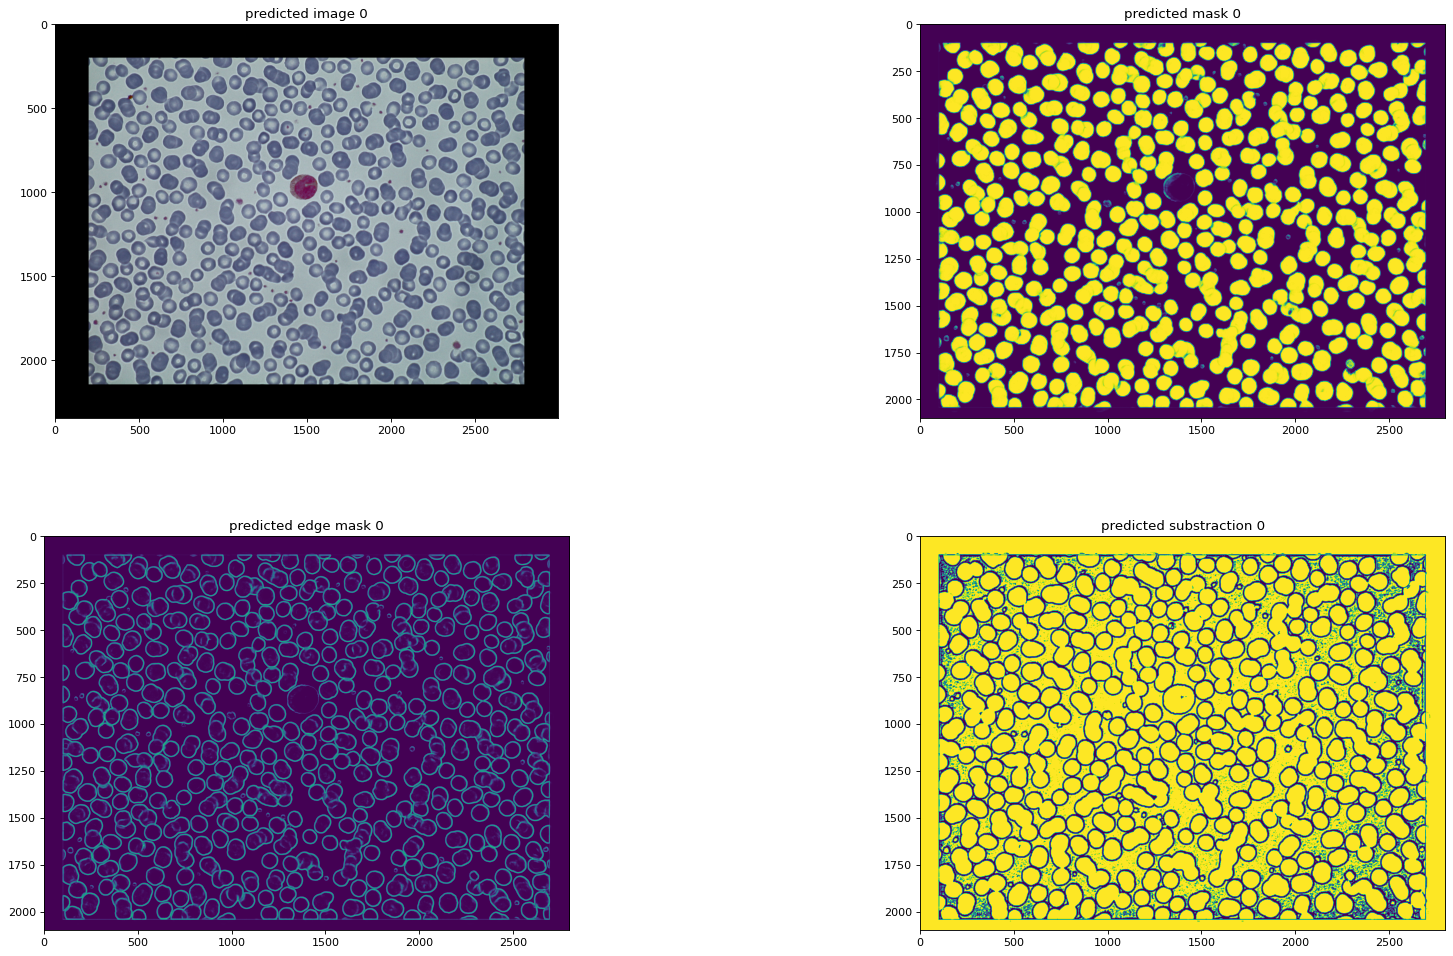

In [70]:
data.plot_ime(images,
              masks,
              edges,
              figSize=(25,15))

